# Compute similarity between credit card to detect abnormal behavior

The goal of this approach is to find credit card that might be similar in terms of age and fico credit score. 
Our intuition is as follow: if two cards are very similar, it is likely that they will behave the same way. 
As a matter of fact, a credit card with a low credit score and being very recent as a higher probability of fraud. 

We therefore need to compute the similarity score between all the cards. 
Later we will do a KNN to identify the 5 closest neighbors and if they have an history of fraudulent transactions
we will then flag them as potentially risky.

Later on, we could also the program they belong too as an extra feature.

In [1]:
import dataiku as dk 

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

import requests 

### Getting access to data 
We are using the dataiku api to directly read the data in database. No need for SQL statement. Sweet :) 

In [2]:
# Load a DSS dataset as a Pandas dataframe
df = dk.Dataset("cardholders_credit_scores_better").get_dataframe(limit=1000)

### Compute the age of the card as an extra feature
We need to compute the age of the card as we will compare all the cards in the plan (fico_score,age_of_card)

In [3]:
# Compute the age of the card as it will be an axis for the similarity computation
df['first_active_month'] = [dt.datetime.strptime(_date,'%Y-%m') for _date in df.first_active_month.values]
df['age_card_days'] = [(max(df['first_active_month']) - _date).days for _date in df.first_active_month.values]
df.head()

,first_active_month,internal_card_num_map,fico_score,reward_program,age_card_days
0,2016-07-01,C_ID_9feec11e78,799.0,dining_entertainment,518
1,2017-09-01,C_ID_8fa2ad405d,778.0,cash_back,91
2,2017-07-01,C_ID_ee82cdf108,587.0,travel,153
3,2017-01-01,C_ID_22ca4a5cdc,501.0,cash_back,334
4,2017-08-01,C_ID_7130fd2b3d,763.0,dining_entertainment,122


### L2 Normalization of the two axis
 
To make sure we can compare things that are comparable, we will use L2 normalizaition on fico and age. Other technics
might actually yiel better results. We should compare against standardization for instance. 


In [8]:
# L2 Normalization of Fico Score and age_card_days
normFicoScore = np.sum([np.power(fico,2) for fico in df.fico_score.values])
normAgeCard = np.sum([np.power(age,2) for age in df.age_card_days.values])

df['l2_norm_fico_score'] = [fico * 1e5 /normFicoScore for fico in  df.fico_score.values] 
df['l2_norm_age_card_days'] = [age * 1e5 /normAgeCard for age in df.age_card_days.values] 

### Plotting - just for fun :) 

We can't see much in the graph. However it seems that we have a lot of new cards with a high credit score. 
This data could be a proof that our recent marketing campaign targetting High Net Worth Individual (HNWI) 
is successful. We might want to ping someone from the marketing team to share our findings. 

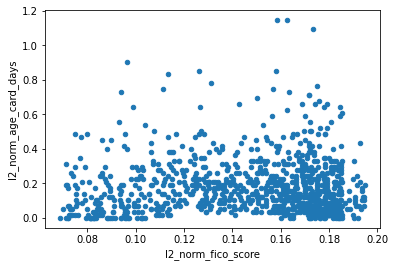

In [6]:
# Plotting just for fun 
df.plot(kind='scatter',x='l2_norm_fico_score',y='l2_norm_age_card_days')

### Cosine Similarity computation 

Classic computation of the cosine similarity between two cards defined as (fico,age). 
Doing it through python is super slow by the way. We might ask someone from the data engineering team to compute that
in SQL directly. The math are not complicated and less prone to errors.

In [6]:
# Similarity - by the way this is super slow - we might have better results implementing that directly in SQL
sim = []
for i in range(df.shape[0]):
    for j in range(i,df.shape[0]):
        dictSim = {'card1':df.internal_card_num_map.values[i],'card2':df.internal_card_num_map.values[j]}
        vectorCard1 = [df.l2_norm_age_card_days[i],df.l2_norm_fico_score[i]]
        vectorCard2 = [df.l2_norm_age_card_days[j],df.l2_norm_fico_score[j]]
        dictSim['sim'] = np.dot(vectorCard1,vectorCard2)/ ( np.linalg.norm(vectorCard1) * np.linalg.norm(vectorCard2) )
        
        sim.append(dictSim)

### End results 

The math are right - the similarity for the same card is 1. 
This is therefore ready to be implemented. 
This dataset should be used as follow: 
    for a given card, identify the K most similar cards. Count the number of fraudulent behavior already recorded 
    for the group of similar cards. This give a white label score. The closest to 0 the best the score.

In [36]:
# End results
df_sim = pd.DataFrame(sim,columns=['card1','card2','sim'])
df_sim.head()

,card1,card2,sim
0,C_ID_9feec11e78,C_ID_9feec11e78,1.000000
1,C_ID_9feec11e78,C_ID_8fa2ad405d,0.743526
2,C_ID_9feec11e78,C_ID_ee82cdf108,0.904530
3,C_ID_9feec11e78,C_ID_22ca4a5cdc,0.999923
4,C_ID_9feec11e78,C_ID_7130fd2b3d,0.803822
